In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler


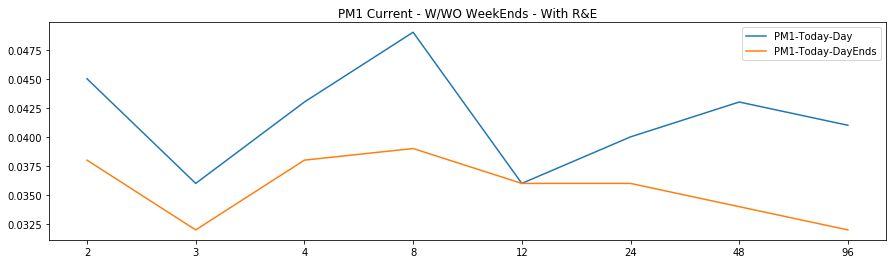

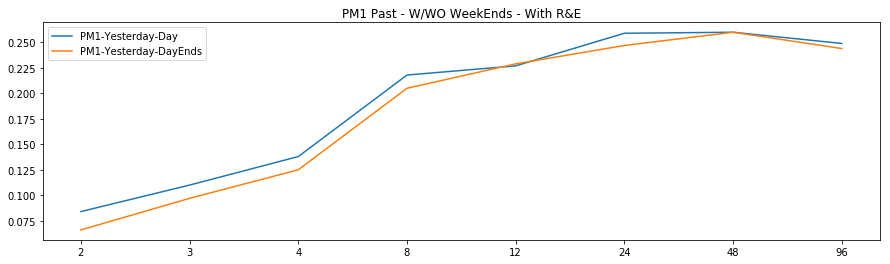

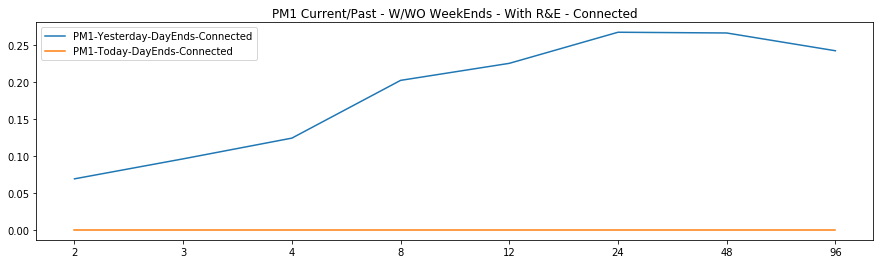

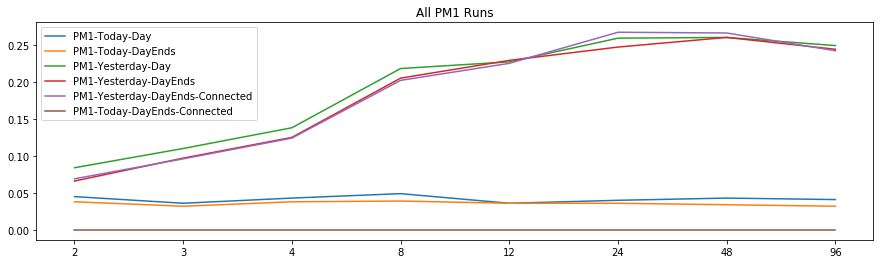

In [32]:
#Experiments Comparison for all windows
line1 = [0.084, 0.110, 0.138, 0.218, 0.227, 0.259,  0.260, 0.249] #PM1 - Yesterday - Weekday
line2 = [0.066, 0.097, 0.125, 0.205, 0.229, 0.247, 0.260, 0.244] #PM1 - Yesterday - WeekdayWeekends
line3 = [0.045, 0.036, 0.043, 0.049, 0.036, 0.040, 0.043, 0.041] #PM1 - Today - Weekday
line4 = [0.038, 0.032, 0.038, 0.039, 0.036, 0.036, 0.034, 0.032] #PM1 - Today - WeekdayWeekends
line5 = [0.069, 0.096, 0.124, 0.202, 0.225, 0.267, 0.266, 0.242] #PM1 - Yesterday - Connected Roads - Weekday
line6 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] #PM1 - Yesterday - Connected Roads - WeekdayWeekends
windows = [2,     3,     4,     8,     12,    24,    48,   96]

plt.figure(figsize=(15, 4))
plt.title("PM1 Current - W/WO WeekEnds - With R&E")
plt.plot(line3, label="PM1-Today-Day")
plt.plot(line4, label="PM1-Today-DayEnds")
plt.legend()
plt.xticks(range(len(windows)), (windows))

plt.figure(figsize=(15, 4))
plt.title("PM1 Past - W/WO WeekEnds - With R&E")
plt.plot(line1, label="PM1-Yesterday-Day")
plt.plot(line2, label="PM1-Yesterday-DayEnds")
plt.legend()
plt.xticks(range(len(windows)), (windows))

plt.figure(figsize=(15, 4))
plt.title("PM1 Current/Past - W/WO WeekEnds - With R&E - Connected")
plt.plot(line5, label="PM1-Yesterday-DayEnds-Connected")
plt.plot(line6, label="PM1-Today-DayEnds-Connected")
plt.legend()
plt.xticks(range(len(windows)), (windows))


plt.figure(figsize=(15, 4))
plt.title("All PM1 Runs")
plt.plot(line3, label="PM1-Today-Day")
plt.plot(line4, label="PM1-Today-DayEnds")
plt.plot(line1, label="PM1-Yesterday-Day")
plt.plot(line2, label="PM1-Yesterday-DayEnds")
plt.plot(line5, label="PM1-Yesterday-DayEnds-Connected")
plt.plot(line6, label="PM1-Today-DayEnds-Connected")
plt.legend()
plt.xticks(range(len(windows)), (windows))



plt.show()

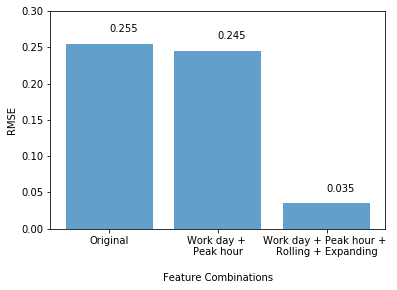

In [20]:
#PM1 Analyzation
rmse = [0.255, 0.245, 0.035]
datasets = ['Original', 'Work day + \nPeak hour', 'Work day + Peak hour + \nRolling + Expanding']

plt.ylim(0, 0.3)

plt.xlabel("\nFeature Combinations")

plt.bar(datasets, rmse, align='center', alpha=0.7)
for a, b in zip(datasets, rmse):
    plt.text(a, b, str(b)+"\n")
    
plt.ylabel("RMSE")
plt.show()

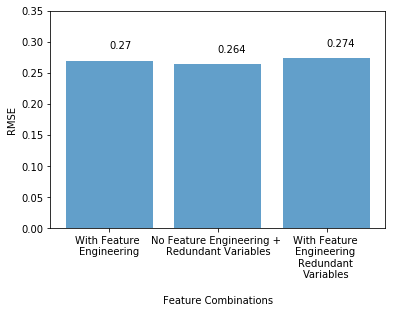

In [25]:
#PM1 Analyzation
rmse = [0.270, 0.264, 0.274]
datasets = ['With Feature \nEngineering', 'No Feature Engineering + \nRedundant Variables', 
            'With Feature \nEngineering \nRedundant \nVariables']

plt.ylim(0, 0.35)

plt.xlabel("\nFeature Combinations")

plt.bar(datasets, rmse, align='center', alpha=0.7)
for a, b in zip(datasets, rmse):
    plt.text(a, b, str(b) + "\n")
    
plt.ylabel("RMSE")
plt.show()

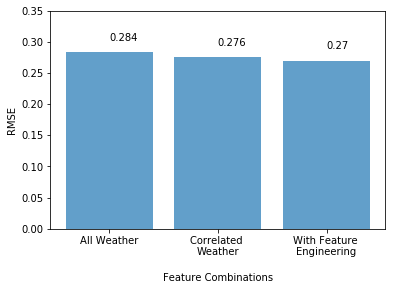

In [22]:
#PM1 Analyzation
rmse = [0.284, 0.276, 0.270]
datasets = ['All Weather', 'Correlated \nWeather', 'With Feature \nEngineering']

plt.ylim(0, 0.35)

plt.xlabel("\nFeature Combinations")

plt.bar(datasets, rmse, align='center', alpha=0.7)
for a, b in zip(datasets, rmse):
    plt.text(a, b, str(b) + "\n")
    
plt.ylabel("RMSE")
plt.show()

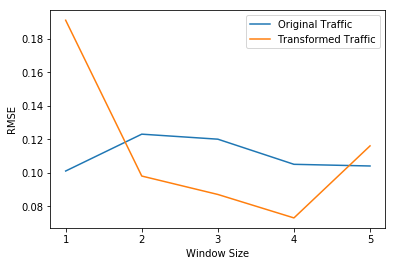

In [9]:
line1 = [0.101, 0.123, 0.120, 0.105, 0.104] #Original Traffic
line2 = [0.191, 0.098, 0.087, 0.073, 0.116] #Transformedraffic
x = np.array(list(range(1, 6)))
plt.plot(x, line1)
plt.plot(x, line2)
plt.xticks(x)
plt.legend(["Original Traffic", "Transformed Traffic"])
plt.xlabel("Window Size")
plt.ylabel("RMSE")

plt.show()

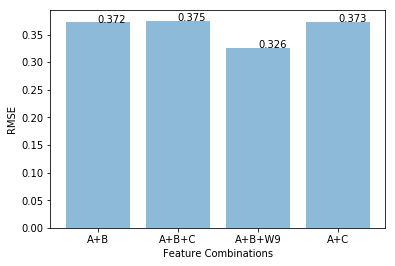

In [33]:
abc = 0.375
ab = 0.372
ac = 0.373
ab9 = 0.326

datasets = ["A+B+C", "A+B", "A+C", "A+B+W9"]
scores = [abc, ab, ac, ab9]

plt.bar(datasets, scores, align='center', alpha=0.5)
for a, b in zip(datasets, scores):
    plt.text(a, b, str(b))
    
plt.xlabel("Feature Combinations")
plt.ylabel("RMSE")
plt.show()

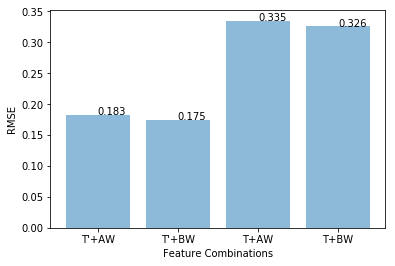

In [41]:
abc = 0.335
ab = 0.183
ac = 0.326
ab9 = 0.175

datasets = ["T+AW", "T'+AW", "T+BW", "T'+BW"]
scores = [abc, ab, ac, ab9]

plt.bar(datasets, scores, align='center', alpha=0.5)
for a, b in zip(datasets, scores):
    plt.text(a, b, str(b))
plt.xlabel("Feature Combinations")
plt.ylabel("RMSE")
plt.show()

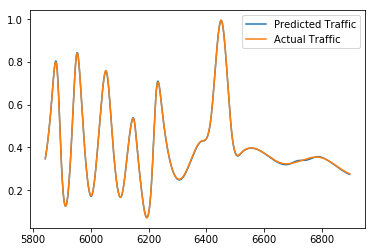

In [65]:
output = pd.read_csv("logs/3-TAFT/fc_output_Taft Ave._2015.csv", skipinitialspace=True)
output.head()

startIndex = 5844
endIndex = 6899

#1 whole month
dt = output.dt[startIndex-2:endIndex-1]
actual = output.Actual[startIndex-2:endIndex-1]
predicted = output.Predicted[startIndex-2:endIndex-1]


plt.plot(predicted)
plt.plot(actual)
plt.legend(["Predicted Traffic", "Actual Traffic"])
plt.show()

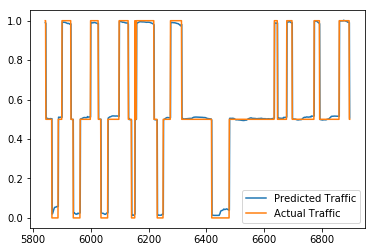

In [67]:
output = pd.read_csv("logs/7-TAFT (Orig Traffic, temp-windspd,temp4,press4)/fc_output_Taft Ave._2015.csv", skipinitialspace=True)
output.head()

startIndex = 5844
endIndex = 6899

#1 whole month
dt = output.dt[startIndex-2:endIndex-1]
actual = output.Actual[startIndex-2:endIndex-1]
predicted = output.Predicted[startIndex-2:endIndex-1]


plt.plot(predicted)
plt.plot(actual)
plt.legend(["Predicted Traffic", "Actual Traffic"])
plt.show()

c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Oct10
Oct11
Oct12
Oct13
Oct14
Oct15
Oct16
Oct17


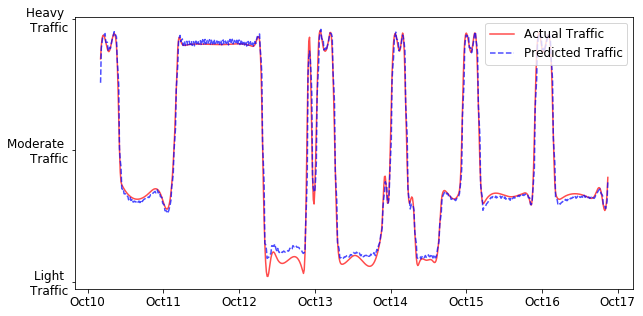

In [37]:
ROAD = "Vicente Cruz"
YEAR = "2015"
EXT = ".csv"

fc_results = pd.read_csv("../output/fc_" + ROAD + "_" + YEAR + EXT, skipinitialspace=True)

line1 = fc_results.Actual[1117:1788]
line2 = fc_results.Predicted[1117:1788]

font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,5))
linestyles = ['-', '--', '-.', ':']

ax.plot(line1, color='red', alpha=0.7, label='Actual Traffic')

fig.canvas.draw()


labels = [""]
for d in fc_results.dt[1110:1789]:
    if "00:00:00" in d:
        temp = d.split(" ")[0].split("-")
        temp = "Oct" + temp[2]
        labels.append(temp)
        print(temp)
           
ax.set_xticklabels(labels)    
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(["Light \nTraffic", "Moderate \nTraffic", "Heavy \nTraffic"])

ax.plot(line2, linestyle=linestyles[1], color='blue', alpha=0.7, label='Predicted Traffic')



ax.legend(loc='upper right')
